# **NEURAL NETWORK**

## Initialize

In [1]:
import os
import io
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, GlobalAveragePooling1D, Bidirectional, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, LearningRateScheduler

In [2]:
# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

# show figures inline
%matplotlib inline

# ignore all warning (NOT recommended)
warnings.filterwarnings("ignore")

## Dataset

### Create a synthetic dataset

**Helper functions**

In [3]:
def plot_ts_data(time, series, line_style='-', start=0, end=None, label=None):
    """
    Plots the graph for time series data
    """
    plt.plot(time[start:end], series[start:end], line_style, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)


def trend(time, slope=0):
    """
    Creates a line with slope.
    """
    return slope * time

def seasonal_pattern(season_time):
    """
    Creates an arbitrary pattern. You can change it.
    """
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """
    Creates a repititive pattern.
    """
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    """
    Creates white noise.
    """
    np.random.seed(seed)
    return np.random.randn(len(time)) * noise_level

**Create a series**

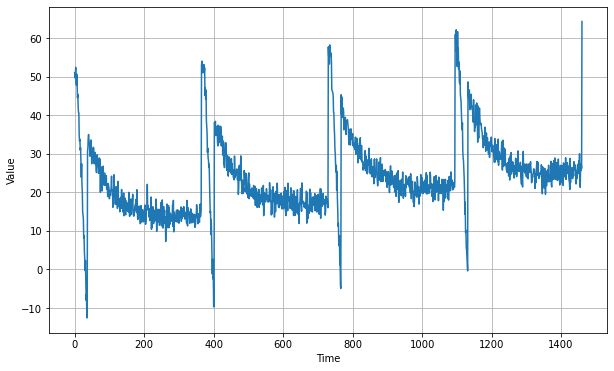

In [4]:
# inputs
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

# create the series
series = baseline\
         + trend(time, slope) \
         + seasonality(time, period=365, amplitude=amplitude) \
         + noise(time, noise_level, seed=42)

# show the series in a graph
plt.figure(figsize=(10, 6))
plot_ts_data(time, series)
plt.show()

**Split the dataset**

In [5]:
# time point to split train and validation data
split_time = 1100

# training data
t_train = time[:split_time]    # time
x_train = series[:split_time]  # values

# validation data
t_valid = time[split_time:]    # time
x_valid = series[split_time:]  # values

# check dataset sizes
print(f'size - training: {len(x_train)}, validation: {len(x_valid)}')

size - training: 1100, validation: 361


**Windowed Dataset**

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer=None, shuffle=True):
    # convert to tfds
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # from the time-series data, iteratively extract data in rolling windows
    # window size = window_size (features) + 1 (label)
    # rolling window shifts 1 time step (shift=1)
    # if the window does not have enough data points, drop it (drop_remainder=True)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)

    # flat the window into chunks
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # shuffle the dataset
    # using 'shuffle_buffer' speeds up shuffling for large dataset
    if shuffle:
        dataset = dataset.shuffle(shuffle_buffer)

    # split features (all but the last data point) and labels (the last one)
    # iteratively return those as tuples
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # iteratively return data in a batch
    dataset = dataset.batch(batch_size).prefetch(1)

    return  dataset

# inputs
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# create windowed dataset
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Evaluation Metrics

**Mean squarred error (MSE)**
- Use when large error is significantly more critical.

**Mean absolute error (MAE)**
- Use when errors are proportionally critical.

In [7]:
# function for calculating MSE
MSE = lambda actual, prediction: np.mean((actual - prediction)**2)
# function for calculating MAE
MAE = lambda actual, prediction: np.mean(abs(actual - prediction))

## Model

In [8]:
def build_model():
    # input layer
    input_tensor = Input(shape=[window_size])

    # hidden layers
    x = Dense(10, activation='relu')(input_tensor)
    x = Dense(10, activation='relu')(x)

    # output layer
    output_tensor = Dense(1)(x)

    # model
    model = tf.keras.Model(input_tensor, output_tensor)

    return model


# create a model
model = build_model()

# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


## Hyper-parameter Tuning
- Get an optimal learning rate.

In [9]:
# callback for learning rate scheduling
# schedule a learning rate for exponential increase
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))

# compile
model.compile(
    optimizer=SGD(lr=1e-8, momentum=0.9),
    loss='mse'
)

# train for 100 epochs
hist = model.fit(
    dataset,
    epochs=100,
    callbacks=[lr_schedule],
    verbose = 0
)

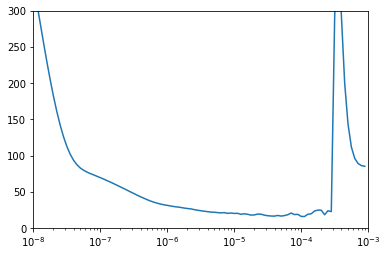

the learning rate with the minimum loss: 0.0001122018454301963


In [10]:
# learning rates
lrs = 1e-8 * 10 ** (np.arange(100) / 20)


# plot the learning rate vs. loss (MSE) graph
plt.figure()
plt.semilogx(lrs, hist.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])
plt.show()

# the learning rate with the minimum loss
idx = np.argmin(hist.history['loss'])
print('the learning rate with the minimum loss:', lrs[idx])

## Train

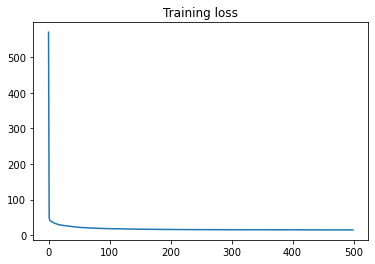

In [11]:
# create a new model
model = build_model()

# compile
model.compile(
    optimizer=SGD(lr=1e-6, momentum=0.9),
    loss='mse'
)

# train for 500 epochs
hist = model.fit(
    dataset,
    epochs=500,
    verbose = 0
)

# plot the loss (MSE) graph
plt.figure()
plt.title('Training loss')
plt.plot(hist.history['loss'])
plt.show()

## Test

In [12]:
# generate inputs from validation data
inputs = []
for time in range(split_time-window_size, len(series) - window_size):
    inputs.append(series[time:time + window_size])

# get predictions
forecast = model.predict(np.array(inputs))[:, 0]

# evaluation metrics
print(f'MSE: {MSE(x_valid, forecast):.6f}')
print(f'MAE: {MAE(x_valid, forecast):.6f}')

MSE: 17.115352
MAE: 2.307967


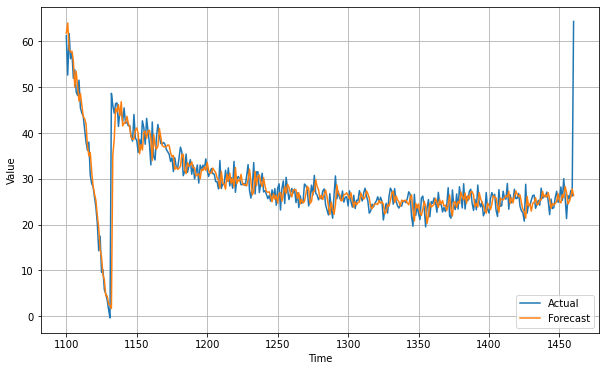

In [13]:
# compare in graph
plt.figure(figsize=(10, 6))
plt.plot(t_valid, x_valid, label='Actual')
plt.plot(t_valid, forecast, label='Forecast')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()